In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x+5  #3x^2 - 4x+5

In [ ]:
f(3)

20

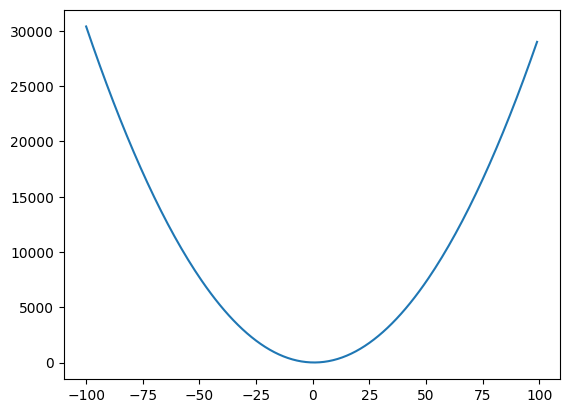

In [ ]:
x_s = np.arange(-100, 100, 1)
y_s = f(x_s)
plt.plot(x_s, y_s)

In [ ]:
#f(3)
s = -3
h = 0.000001
(f(s+h)-f(s))/h

-21.999997002808414

In [ ]:
a=2
b=-3
c=10
d = a*b + c
print(d)

h=0.000001

a+=h

d1 = a*b + c

print('d1', d1)
print('d', d)

slope = (d1 - d)/h

print('slope', slope)

4
d1 3.9999969999999996
d 4
slope -3.000000000419334


In [ ]:
class Value:
  def __init__(self, data, _children=(), _op = ''):
    self.data = data
    self.prev = set(_children)
    self._op = _op

  def __repr__(self):                             #printing out proper value in decimal values
    return f"Value(data={self.data})"

  def __add__(self, other):
    # Check if the other operand is a Value object
    if isinstance(other, Value):
        o1 = Value(self.data + other.data, (self, other), '+')
    else:
        # Assume it's a standard numerical type like int or float
        o1 = Value(self.data + other, (self, other), '+')
    return o1

  def __mul__(self, other):
    # Similarly, handle multiplication with non-Value objects
    if isinstance(other, Value):
        o1 = Value(self.data * other.data,(self, other), '*' )
    else:
        o1 = Value(self.data * other, (self, other), '*')
    return o1

a = Value(2)
b = Value(3)
c = 10
p = a+b
print('add', p)
q = a*b
print('mul', q)
# Now this line should work correctly
d = a*b+c
print('a*b+c', d)

add Value(data=5)
mul Value(data=6)
a*b+c Value(data=16)


In [ ]:
d.prev

{10, Value(data=6)}

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    # Handle addition with non-Value objects
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out


  def __mul__(self, other):
    # Handle multiplication with non-Value objects
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [ ]:
a = Value(2.0)
b = Value(4.0)
a**2

Value(data=4.0)

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
L.grad = 1.0000
d.grad = -2.0000
f.grad = 4.0000
c.grad = -2.0000
e.grad = -2.0000
a.grad = -2.0000*-3.0000
b.grad = -2.0000*2.0000

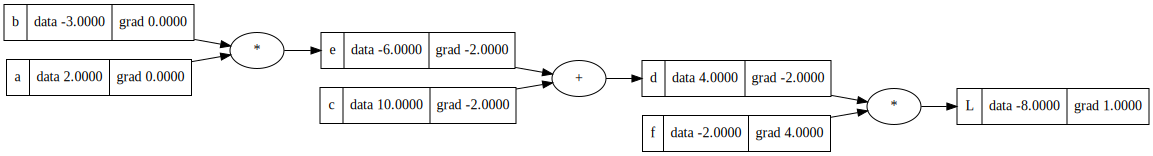

In [ ]:
draw_dot(L)

In [ ]:
a.data+=0.01*a.grad
b.data+=0.01*b.grad
c.data+=0.01*c.grad
f.data+=0.01*f.grad

e = a*b
d = c+e
L = d*f

print(L.data)

-35.549696


In [ ]:
def lol():

  h = 0.001

  a = Value(2.0, (), '', 'a')
  b = Value(-3.0, (), '', 'b')
  c = Value(10.0, (), '', 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, (), '', 'f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, (), '', 'a')
  b = Value(-3.0, (), '', 'b')
  b.data += h
  c = Value(10.0, (), '', 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, (), '', 'f')
  L = d * f; L.label = 'L'
  L2 = L.data+h

  print((L2 - L1)/h)

lol()

-3.0000000000001137


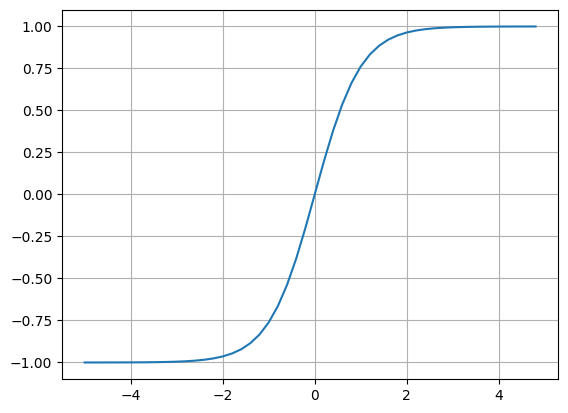

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
#o = n.tanh()
o.label = 'o'
o.backward()

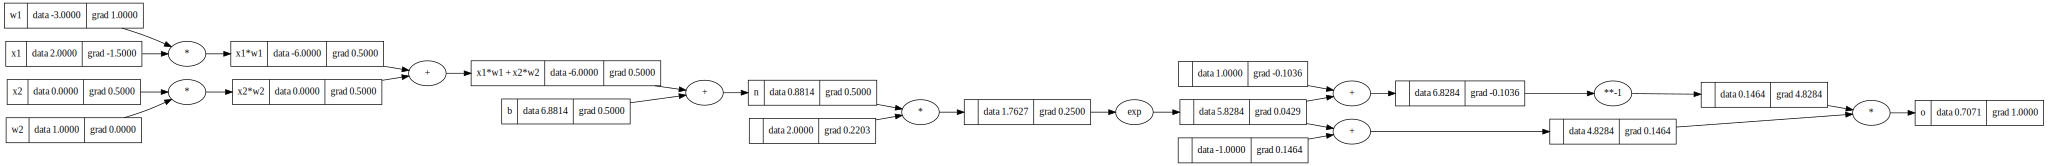

In [ ]:
draw_dot(o)

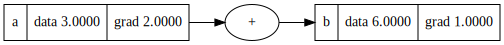

In [ ]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

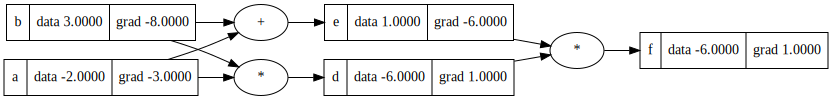

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
o
x1.data

tensor([2.], dtype=torch.float64)

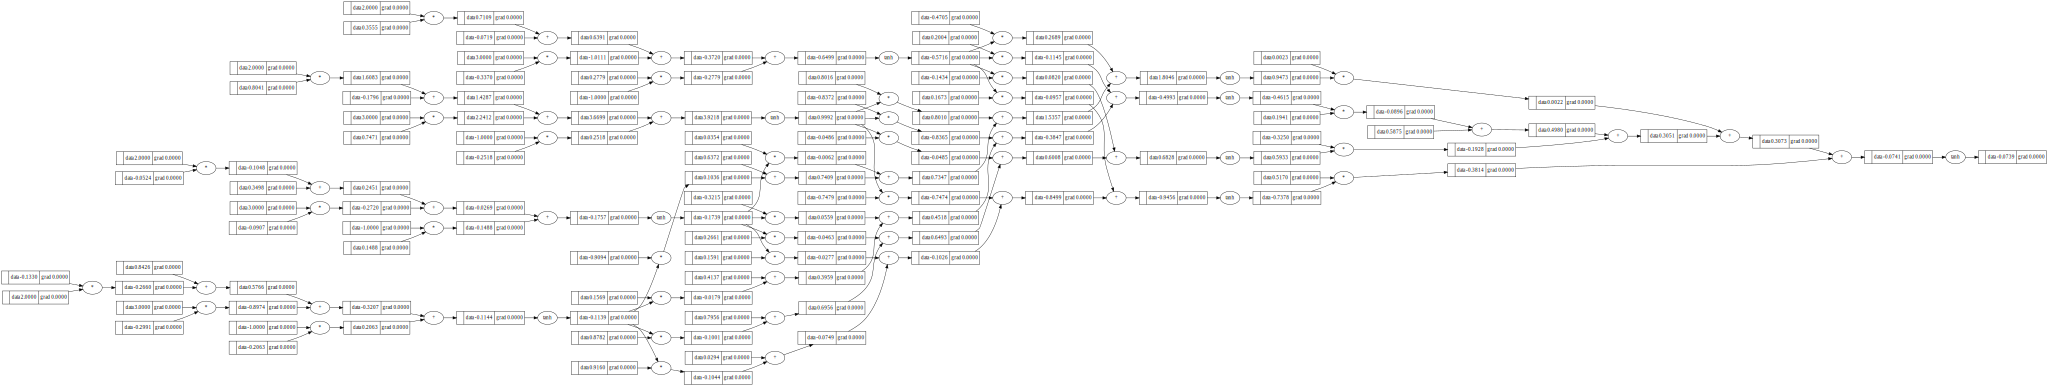

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
draw_dot(n(x))

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.07394168051609756),
 Value(data=0.32296468835103526),
 Value(data=0.23060823725357907),
 Value(data=0.1383066833398703)]

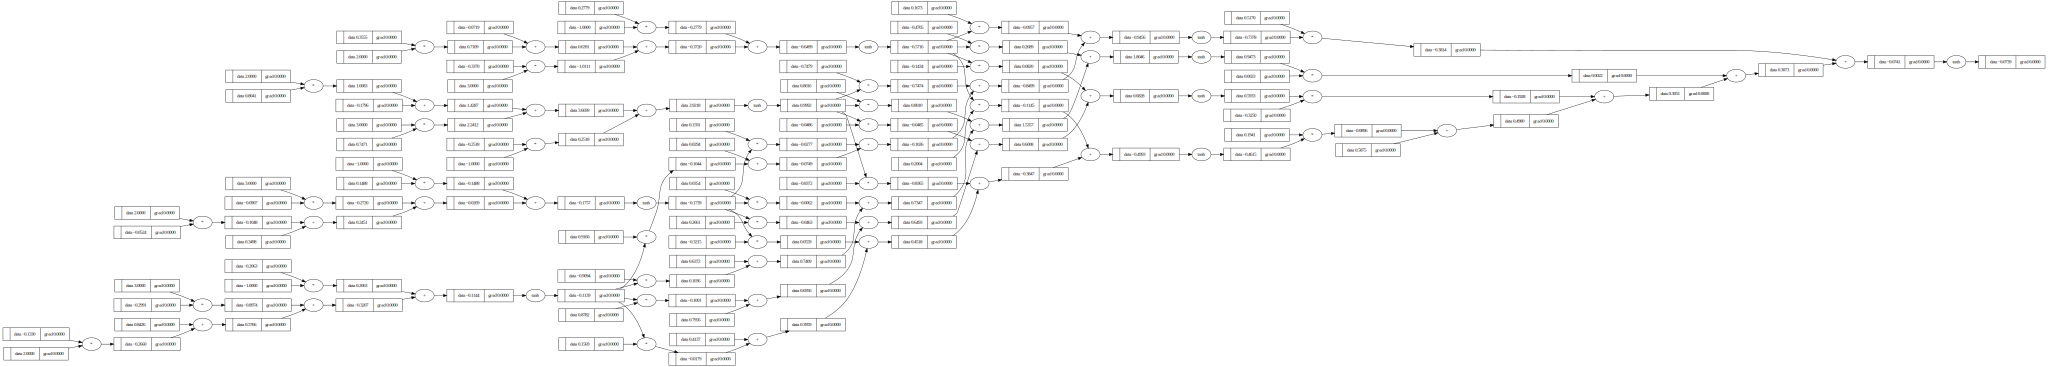

In [ ]:
draw_dot(ypred[0])

In [ ]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.024946936246497724)

In [ ]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss              #more number of time iteration will give better result in the output

Value(data=0.010442887375452934)

In [ ]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)


0 0.010137261178554707
1 0.00984825038112375
2 0.009574556804825054
3 0.009315013068123533
4 0.009068566584065942
5 0.008834265846156868
6 0.00861124862993485
7 0.008398731805522267
8 0.00819600251056211
9 0.008002410476509111
10 0.007817361336460316
11 0.007640310771330862
12 0.007470759374549331
13 0.007308248134610152
14 0.007152354450606995
15 0.007002688608926722
16 0.006858890660122727
17 0.006720627644021744
18 0.006587591118675225
19 0.006459494955108924


In [ ]:
n.layers[0].neurons[0].w[0].data

-0.31843976310062105

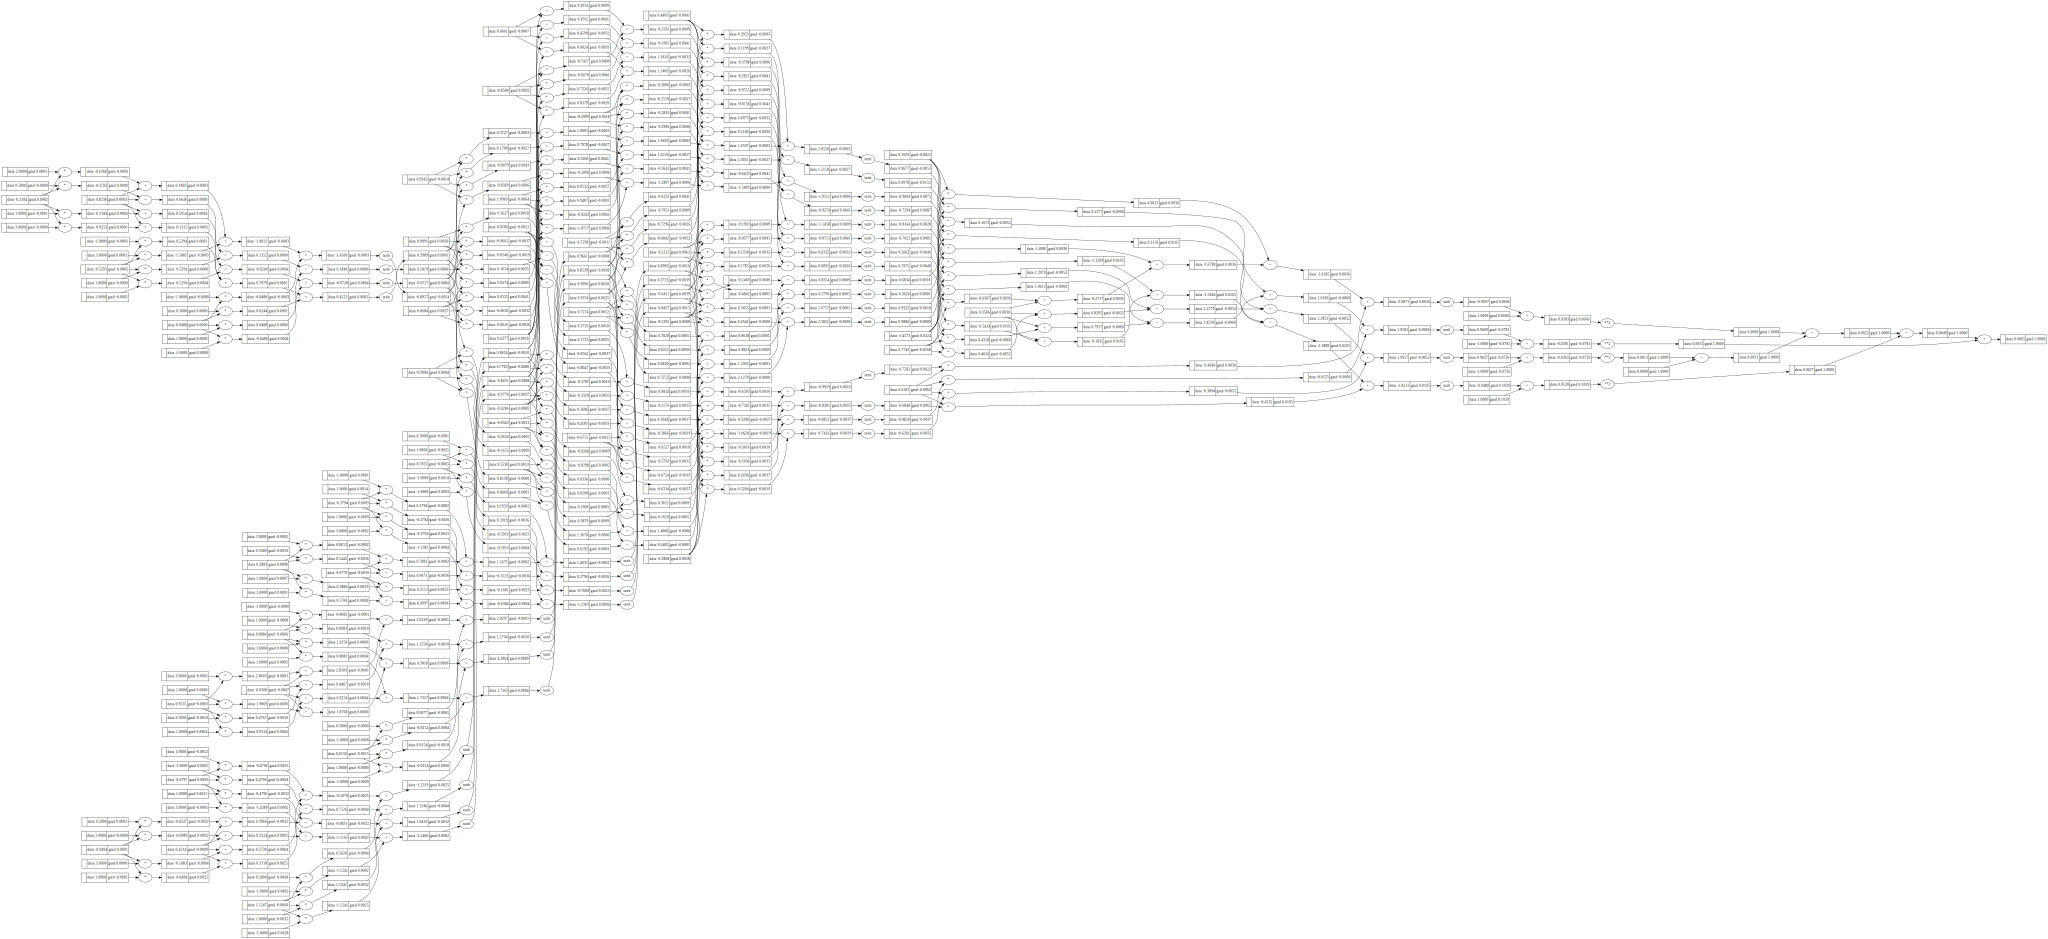

In [ ]:
draw_dot(loss)

In [ ]:
ypred

[Value(data=0.9637211016758589),
 Value(data=-0.9696904657644374),
 Value(data=-0.9480446478678916),
 Value(data=0.9609447825412861)]